In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import lime.lime_tabular
import shap
import numpy as np

In [3]:
# Load the dataset, skipping bad lines
file_path = 'Base Paper Dataset.csv'
df = pd.read_csv(file_path, on_bad_lines='skip')

# Display the first few rows
print(df.head())

              District_Name       Season     Area  Production Crop
0  NORTH AND MIDDLE ANDAMAN  Rabi           294.5        90.8  Tur
1            SOUTH ANDAMANS  Rabi            20.5        13.2  Tur
2                 ANANTAPUR  Kharif       21400.0      2600.0  Tur
3                 ANANTAPUR  Kharif       27400.0      9100.0  Tur
4                 ANANTAPUR  Kharif       30693.0      7888.0  Tur


In [4]:
# Drop rows where 'Production' is NaN
df_cleaned = df.dropna(subset=['Production'])

# Define features and target
X = df_cleaned.drop(columns='Production')
y = df_cleaned['Production']

# Convert all columns to numeric if possible
for col in X.select_dtypes(include='object').columns:
    X[col] = pd.to_numeric(X[col], errors='coerce')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Ensure no NaNs or infinite values in training and testing data
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test.replace([np.inf, -np.inf], np.nan, inplace=True)

In [5]:
# Define preprocessing
categorical_features = ['District_Name', 'Season', 'Crop']
numerical_features = ['Area']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor())
])

# Define hyperparameters for GridSearchCV
param_grid = {
    'model__n_estimators': [50, 100],
    'model__max_depth': [3, 5],
    'model__min_samples_split': [2, 5]
}

# Perform Grid Search with cross-validation
grid_search = GridSearchCV(pipeline, param_grid, cv=5, error_score='raise')
grid_search.fit(X_train, y_train)
best_rf = grid_search.best_estimator_

In [6]:
# Model evaluation
y_pred = best_rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"MSE: {mse}, MAE: {mae}, R2: {r2}")

MSE: 603701517086625.9, MAE: 2269066.2223107773, R2: 0.01385298667460877


C:\Users\ur_mi\anaconda3\Lib\site-packages\numpy\lib\nanfunctions.py:1384: RuntimeWarning: All-NaN slice encountered
  return _nanquantile_unchecked(


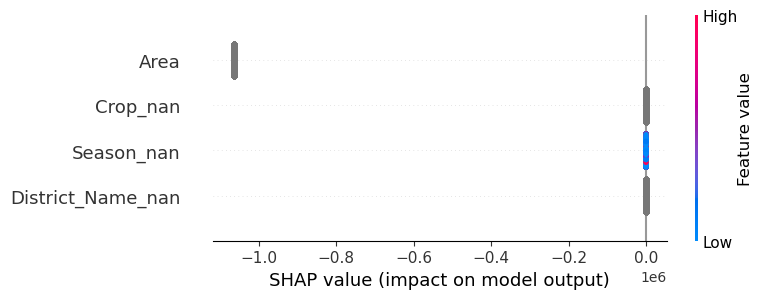

In [9]:
import shap
# Model interpretation with SHAP
explainer = shap.TreeExplainer(best_rf.named_steps['model'])
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test, feature_names=feature_names)

In [10]:
import lime.lime_tabular
# Extract feature names after fitting
preprocessor = best_rf.named_steps['preprocessor']
onehot = preprocessor.named_transformers_['cat']
onehot_feature_names = onehot.get_feature_names_out(categorical_features)
feature_names = numerical_features + list(onehot_feature_names)

# Ensure the data passed to LIME is clean
X_test_clean = X_test.copy()
X_test_clean.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_clean.fillna(X_test_clean.mean(), inplace=True)

# Debugging information
print("Feature names for LIME:", feature_names)
print("First instance for LIME explanation:", X_test_clean.iloc[0].values)

# Model interpretation with LIME
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values,
    feature_names=feature_names,
    mode='regression'
)

# Debug LIME with first instance
try:
    exp = explainer.explain_instance(X_test_clean.iloc[0].values, best_rf.predict, num_features=10)
    exp.show_in_notebook()
except Exception as e:
    print(f"Error explaining instance with LIME: {e}")


Feature names for LIME: ['Area', 'District_Name_nan', 'Season_nan', 'Crop_nan']
First instance for LIME explanation: [   nan    nan 60100.    nan]


C:\Users\ur_mi\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1047: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\ur_mi\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1052: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
C:\Users\ur_mi\anaconda3\Lib\site-packages\sklearn\utils\extmath.py:1072: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Error explaining instance with LIME: Domain error in arguments. The `scale` parameter must be positive for all distributions, and many distributions have restrictions on shape parameters. Please see the `scipy.stats.truncnorm` documentation for details.


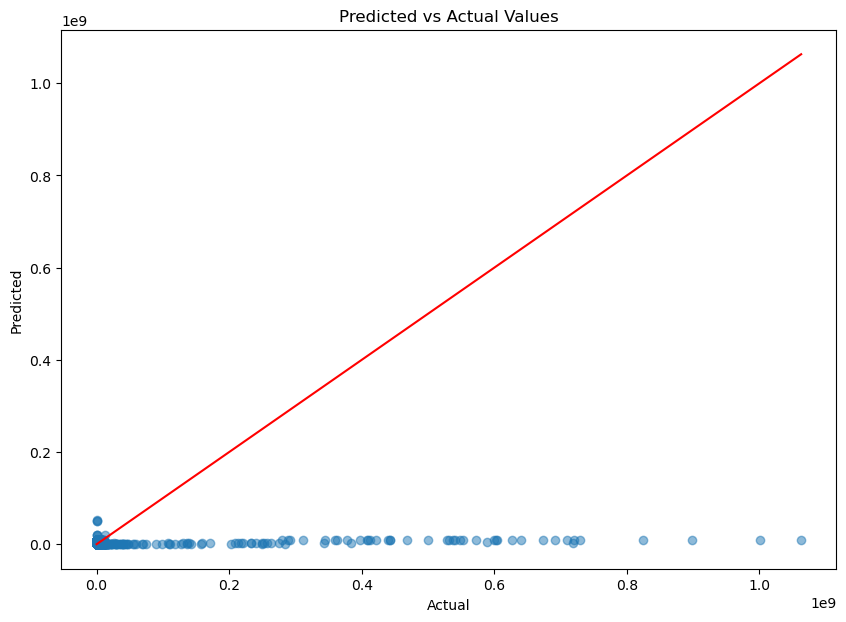

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of predicted vs actual values
plt.figure(figsize=(10, 7))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual Values')
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')  # Diagonal line
plt.show()

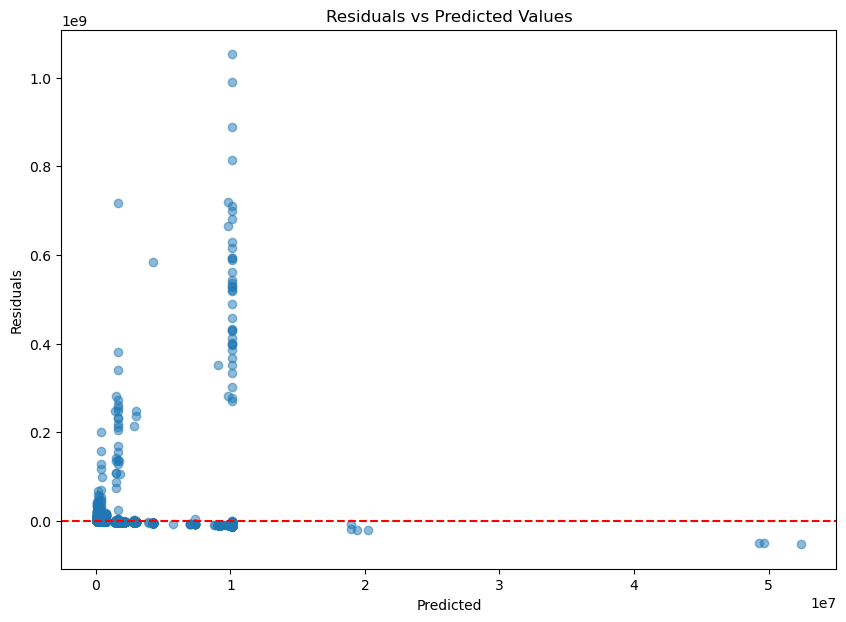

In [12]:
residuals = y_test - y_pred

# Residual plot
plt.figure(figsize=(10, 7))
plt.scatter(y_pred, residuals, alpha=0.5)
plt.axhline(y=0, color='red', linestyle='--')
plt.xlabel('Predicted')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values')
plt.show()